Good ol' MNIST.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

train = tfds.load(name="mnist", split=tfds.Split.TRAIN)
test = tfds.load(name="mnist", split=tfds.Split.TEST)

train = train.shuffle(1024).batch(32)



TensorFlow 2.x selected.


Let's visualize the first batch.



(32, 28, 28, 1)


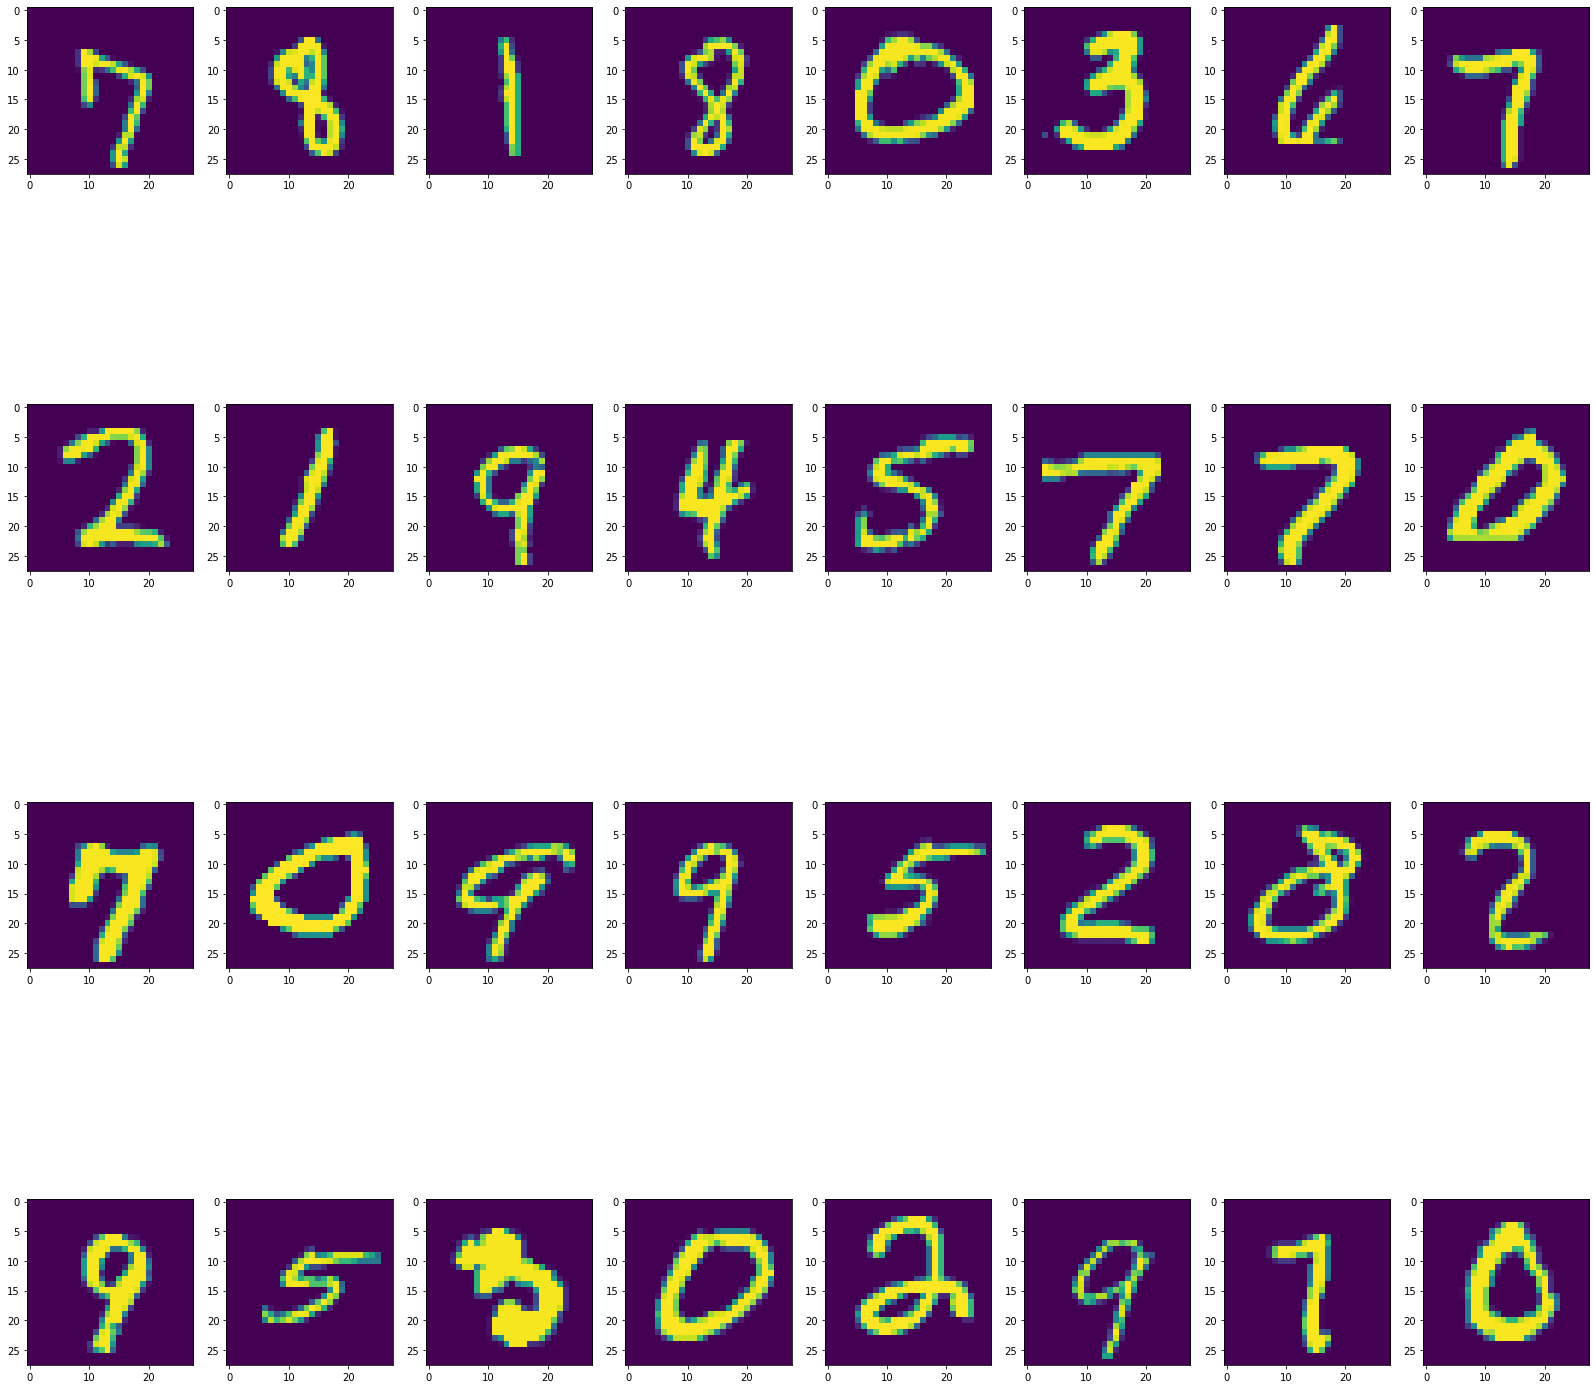

In [2]:
first_batch = tfds.as_numpy(train).__next__()
batch = first_batch['image']
labels = first_batch['label']
print(batch.shape)

fig=plt.figure(figsize=(28, 28))
columns = 8
rows = 4
for i in range(1, columns*rows + 1):
  img = batch[i-1].reshape(28,28)
  fig.add_subplot(rows, columns, i)
  plt.imshow(img)
plt.show()

# sample = image[0].numpy()
# sample = sample.reshape((28,28))

# plt.imshow(sample)
# plt.show()

Creating a simple Convnet to classify the digits.

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(
    32,
    (3, 3), 
    activation='relu',
    input_shape=(28,28,1)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________
None


Add fully connected layer to finish the classifier after feature extraction.

In [4]:
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

Let's prepare our input data pipeline.
* Normalize the image data from [0, 255] to [0.0, 1.0]




In [5]:
print("Max value on a image is:")
print(batch[0].max())

print("Type of label is.")
print(type(labels[0]))

Max value on a image is:
255
Type of label is.
<class 'numpy.int64'>


In [0]:
def prepare_mnist(example):
  prepared_batch = example['image']
  prepared_label = example['label']
  
  prepared_batch = tf.dtypes.cast(prepared_batch, tf.float32)
  prepared_batch = prepared_batch / 255
  prepared_label = prepared_label
  prepared_label = tf.one_hot(prepared_label, 10)
  return prepared_batch, prepared_label

Check that the preparation function formats the inputs and outputs in the expect format to work with our model.

Let's learn the representation on the training data.

In [0]:
train = train.map(map_func=prepare_mnist)

In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.1353 - accuracy: 0.9583
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0426 - accuracy: 0.9875
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0302 - accuracy: 0.9911
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0238 - accuracy: 0.9935
Epoch 5/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0182 - accuracy: 0.9951


dict_keys(['loss', 'accuracy'])


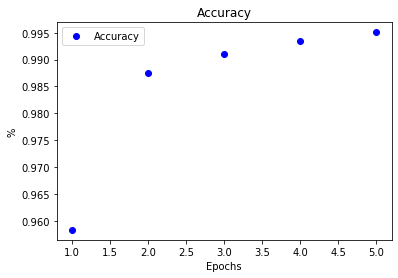

In [9]:
history_dict = history.history
print(history_dict.keys())

epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.show()

Evaluate the model on the test data.

In [0]:
test = test.batch(32).take(10000).map(map_func=prepare_mnist)

In [11]:
test_loss, test_accuracy = model.evaluate(test)
print(test_accuracy)

313/313 [==============================] - 3s 10ms/step - loss: 0.0355 - accuracy: 0.9901
0.9901


Likely overfitting at this point. But the model is performing exceedingly well.

Some considerations to explore in the future
* Training data augmentation
* More regulariztion
* Hyperparameter searching
* Add validation data set to determine when overfitting starts
* Futher experiments

Save the model so that we can use it to reevaluate without training.

In [0]:
from google.colab import files
save_path = 'trained_weights.h5'
model.save(save_path)
files.download(save_path)